Датасет для роботи:

https://fred.stlouisfed.org/series/T10Y2Y

На вибір - SARIMA(ARIMA), Darts, Prophet

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ExponentialSmoothing

In [3]:
database = pd.read_csv("T10Y2Y.csv", sep = ',',index_col=['DATE'],  parse_dates=['DATE'], keep_default_na=False, dayfirst=True)

In [4]:
print(database.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2018-03-06 to 2023-03-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T10Y2Y  1305 non-null   object
dtypes: object(1)
memory usage: 20.4+ KB
None


In [5]:
database

,T10Y2Y
DATE,
2018-03-06,0.63
2018-03-07,0.64
2018-03-08,0.61
2018-03-09,0.63
2018-03-12,0.6
...,...
2023-02-28,-0.89
2023-03-01,-0.88
2023-03-02,-0.81


попытавшись перевести базу данных в числовое значение, понял что на некоторых местах стоят просто точки. сравнив с экселем сделал вывод, что на этих местах должны быть нули. но после построения графика стало понятно, что это ошибка, заменим эти значения на nan

In [6]:
database['T10Y2Y'].loc[database['T10Y2Y'] == '.'] = np.nan

In [7]:
database['T10Y2Y'] = database['T10Y2Y'].astype(float)

In [8]:
print(database.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2018-03-06 to 2023-03-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10Y2Y  1250 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB
None


<AxesSubplot: xlabel='DATE'>

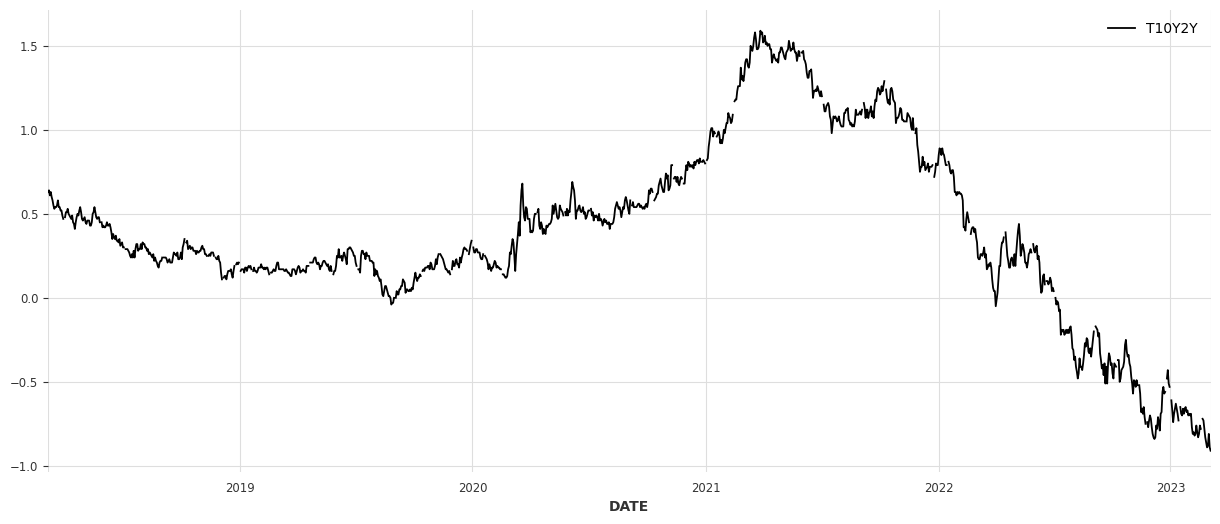

In [9]:
database.plot(figsize=(15, 6))

так как у нас есть пример на сайте, делаем вывод что график построе правильно, но nan Значения оставлять не хотелось бы

In [10]:
database['T10Y2Y'] = database['T10Y2Y'].interpolate()

In [11]:
print(database.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2018-03-06 to 2023-03-06
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10Y2Y  1305 non-null   float64
dtypes: float64(1)
memory usage: 20.4 KB
None


<AxesSubplot: xlabel='DATE'>

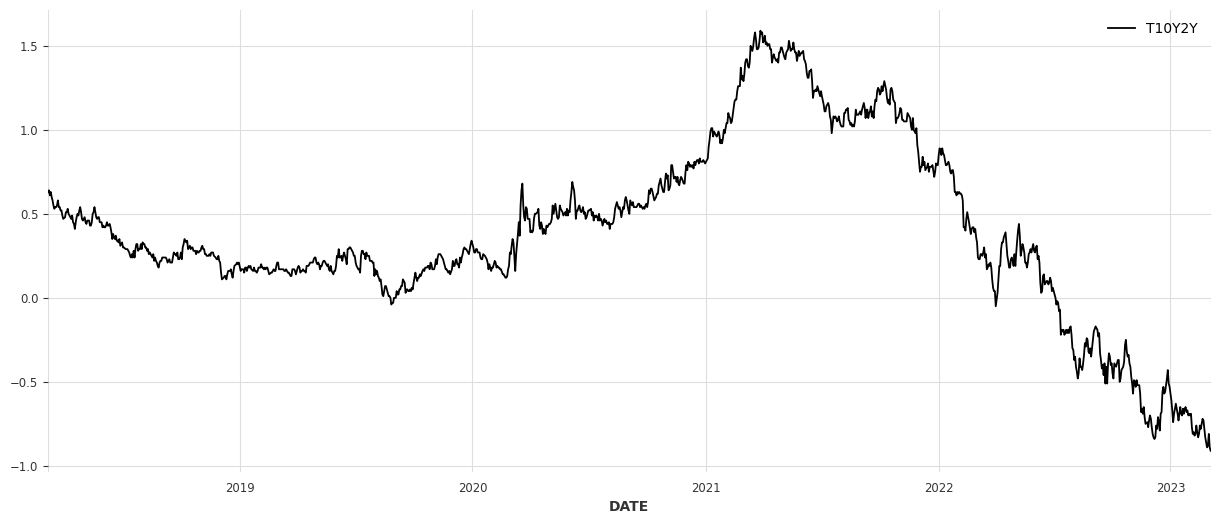

In [12]:
database.plot(figsize=(15, 6))

In [13]:
database = database.resample('w').mean()

<AxesSubplot: xlabel='DATE'>

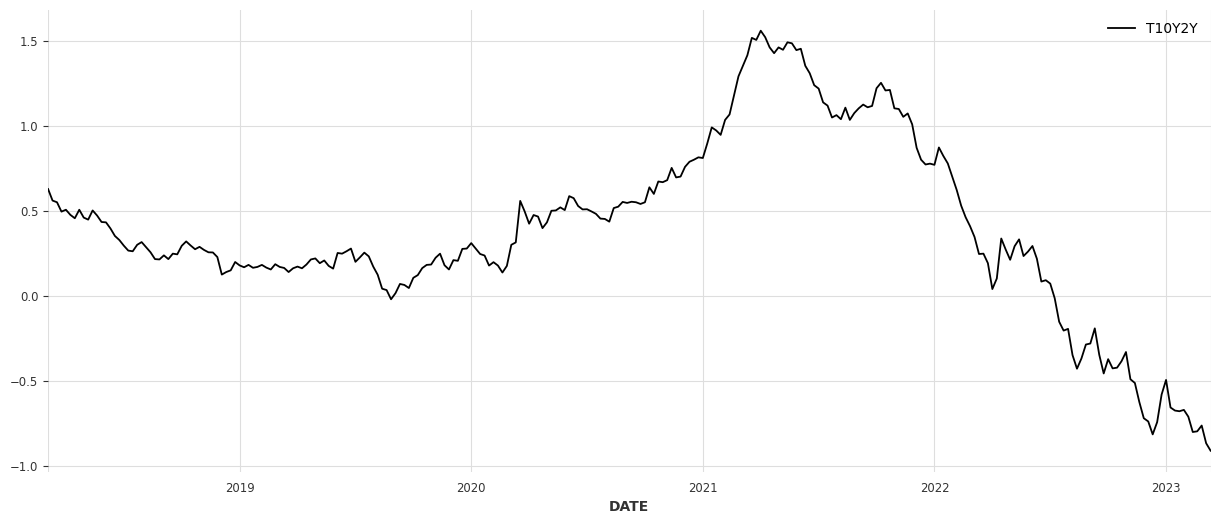

In [14]:
database.plot(figsize=(15, 6))

In [15]:
jb_test = sm.stats.stattools.jarque_bera(database)

In [16]:
print(jb_test)

(array([0.07722171]), array([0.96212504]), array([-7.39738707e-05]), array([3.08410543]))


Это значения ['JB', 'p-value', 'skew', 'kurtosis'] соответственно наше распределение далеко от нормального, сейчас подтвердим єто по графику

<AxesSubplot: >

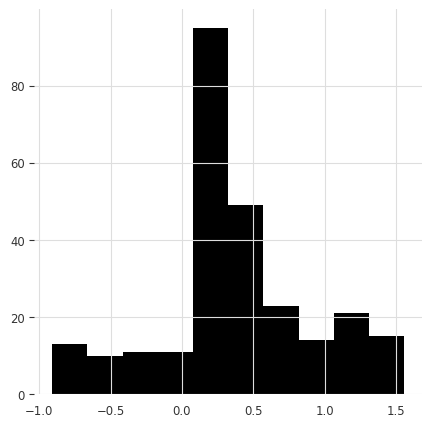

In [17]:
database['T10Y2Y'].hist(figsize=(5,5))

проведем тест Дикки Фуллера на стационарность

In [18]:
test = sm.tsa.adfuller(database)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  0.08736939067115124
p-value:  0.9651880882762542
Critical values:  {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}
есть единичные корни, ряд не стационарен


определим порядок интегрированного ряда

In [19]:
data1diff = database.diff(periods=1).dropna()

In [20]:
test = sm.tsa.adfuller(data1diff)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.4343347491095635
p-value:  6.240631467356619e-11
Critical values:  {'1%': -3.455952927706342, '5%': -2.8728086526320302, '10%': -2.572774990685656}
единичных корней нет, ряд стационарен


проверим наличие тренда построением графика

<AxesSubplot: xlabel='DATE'>

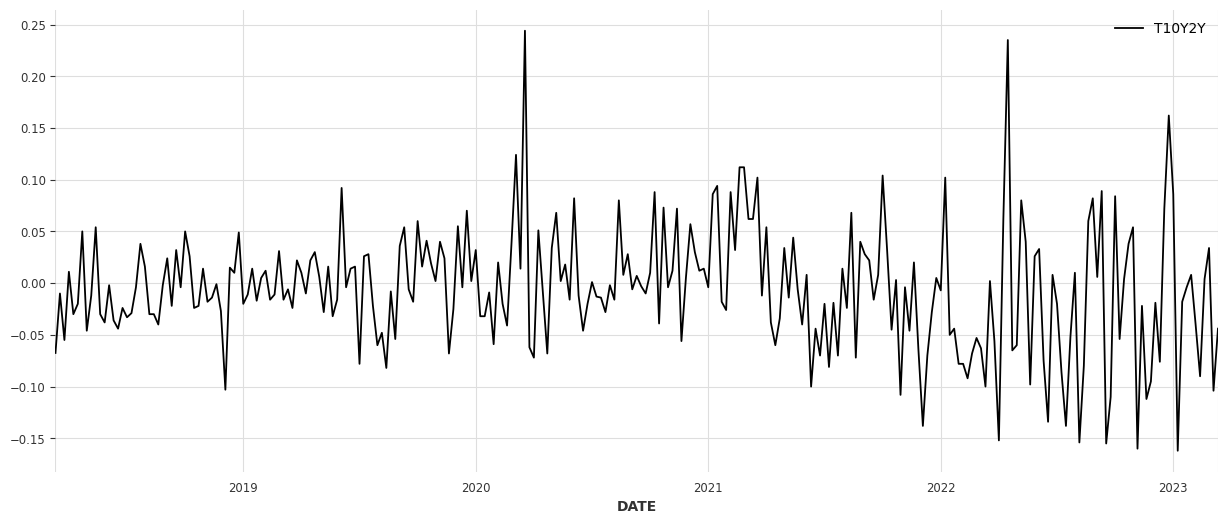

In [21]:
data1diff.plot(figsize=(15,6))

тренда на графике не видно

d:\programs\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


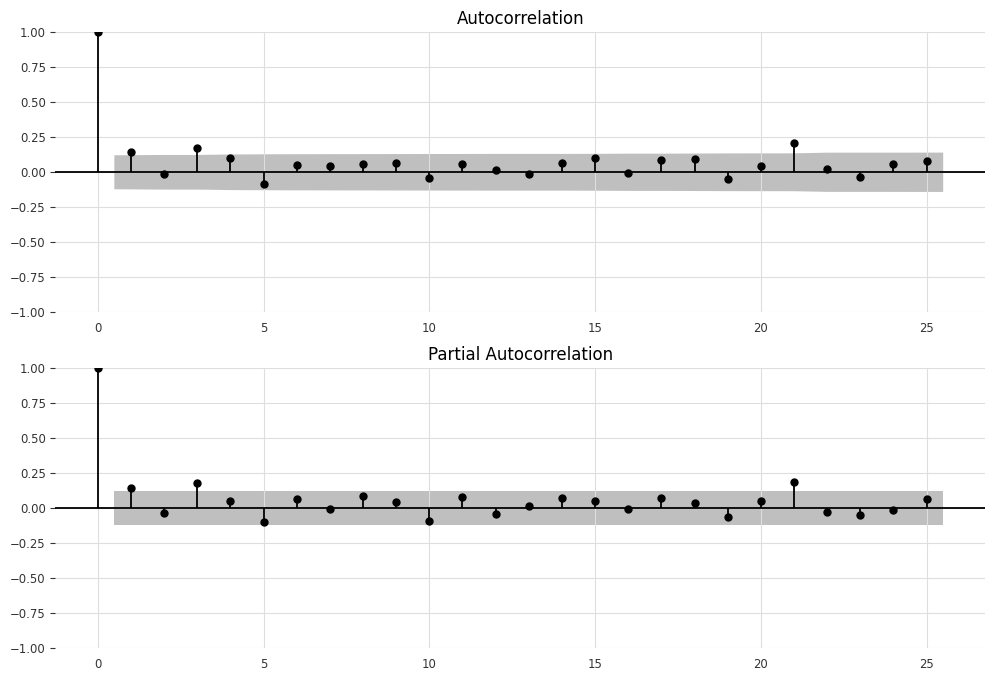

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data1diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data1diff, lags=25, ax=ax2)

для обучения модели возьмем данные до сентября 2022 года, попробуем значения p и q равные 1 и 3

In [23]:
src_data_model = database[:'2022-09-01']

In [24]:
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                  234
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 348.696
Date:                Thu, 09 Mar 2023   AIC                           -691.392
Time:                        22:34:13   BIC                           -681.039
Sample:                    03-11-2018   HQIC                          -687.217
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8345      0.096      8.704      0.000       0.647       1.022
ma.L1         -0.7115      0.131     -5.418      0.000      -0.969      -0.454
sigma2         0.0029      0.000     14.764      0.0

In [25]:
model = sm.tsa.ARIMA(src_data_model, order=(1,1,3), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                  234
Model:                 ARIMA(1, 1, 3)   Log Likelihood                 352.306
Date:                Thu, 09 Mar 2023   AIC                           -694.612
Time:                        22:34:13   BIC                           -677.357
Sample:                    03-11-2018   HQIC                          -687.654
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5123      0.223      2.300      0.021       0.076       0.949
ma.L1         -0.3765      0.223     -1.688      0.091      -0.814       0.061
ma.L2         -0.0345      0.059     -0.580      0.5

In [26]:
model = sm.tsa.ARIMA(src_data_model, order=(3,1,1), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                  234
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 353.292
Date:                Thu, 09 Mar 2023   AIC                           -696.583
Time:                        22:34:13   BIC                           -679.328
Sample:                    03-11-2018   HQIC                          -689.625
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3896      0.249      1.563      0.118      -0.099       0.878
ar.L2         -0.0663      0.062     -1.062      0.288      -0.188       0.056
ar.L3          0.2333      0.066      3.531      0.0

In [27]:
model = sm.tsa.ARIMA(src_data_model, order=(3,1,3), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                  234
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 357.021
Date:                Thu, 09 Mar 2023   AIC                           -700.042
Time:                        22:34:14   BIC                           -675.885
Sample:                    03-11-2018   HQIC                          -690.301
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5653      0.126      4.501      0.000       0.319       0.812
ar.L2         -0.7245      0.105     -6.924      0.000      -0.930      -0.519
ar.L3          0.6817      0.123      5.549      0.0

d:\programs\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


результаты лучше при p=3 и q=3 оставляем подель на последнем варианте

<AxesSubplot: xlabel='DATE'>

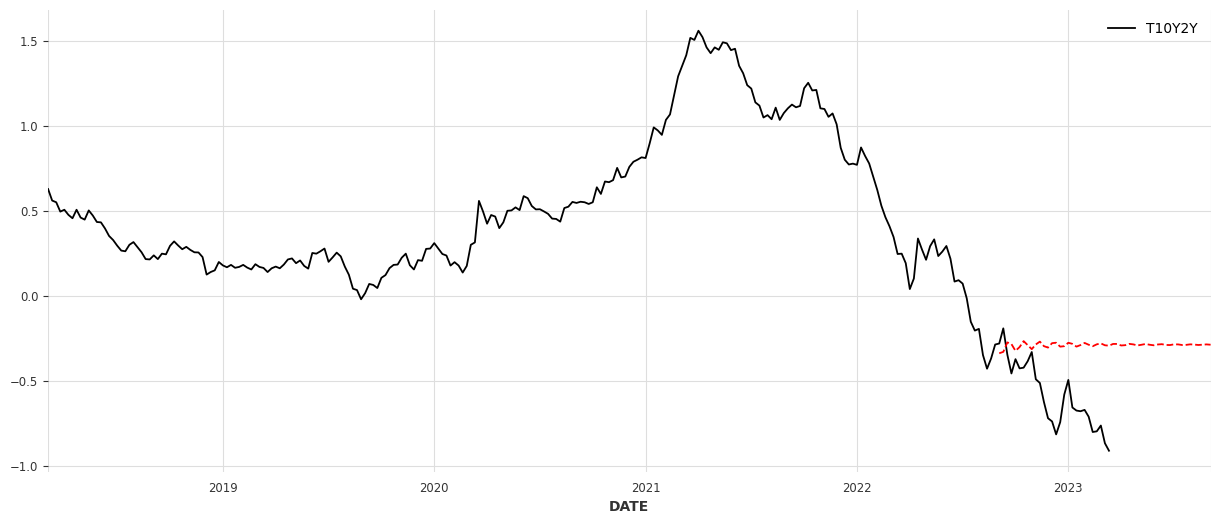

In [28]:
pred = model.predict('2022-09-01','2023-09-01', typ='levels')
database.plot(figsize=(15, 6))
pred.plot(style='r--')

результат получился не очень, попробуем с параметрами p и q равными 21

In [29]:
model = sm.tsa.ARIMA(src_data_model, order=(21,1,21), freq='W').fit()
print(model.summary())

d:\programs\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                  234
Model:               ARIMA(21, 1, 21)   Log Likelihood                 375.160
Date:                Thu, 09 Mar 2023   AIC                           -664.319
Time:                        22:34:25   BIC                           -515.925
Sample:                    03-11-2018   HQIC                          -604.480
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4355      0.720      0.605      0.545      -0.976       1.847
ar.L2         -0.0890      0.841     -0.106      0.916      -1.737       1.559
ar.L3         -0.0393      0.787     -0.050      0.9

<AxesSubplot: xlabel='DATE'>

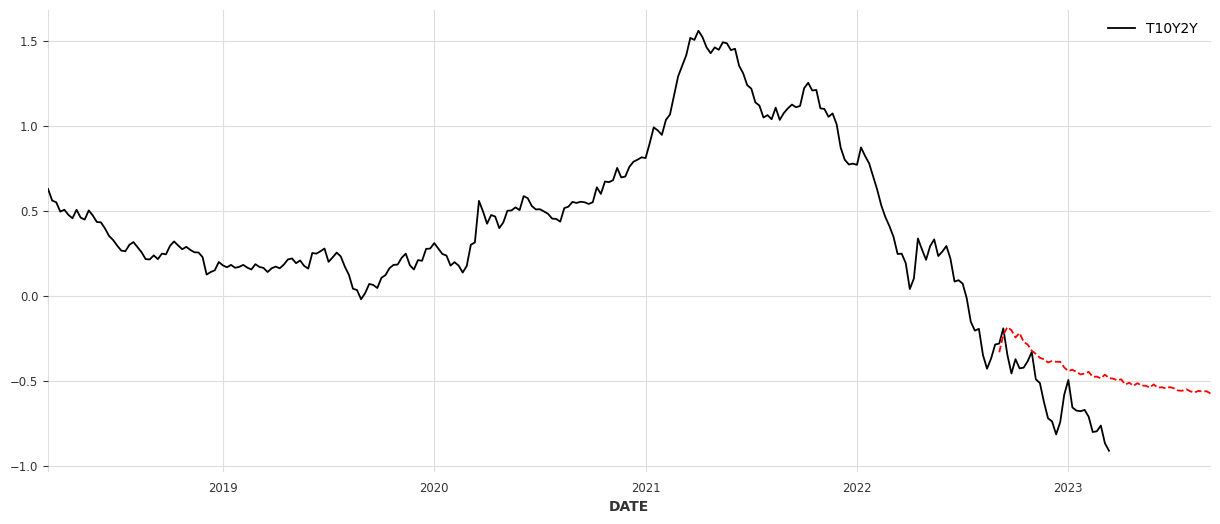

In [30]:
pred = model.predict('2022-09-01','2023-09-01', typ='levels')
database.plot(figsize=(15, 6))
pred.plot(style='r--')

попробуем проделоть тоже, но взять период не в 5 лет, а в 20, сверим результаты

In [31]:
database2 = pd.read_csv("20.csv", sep = ',',index_col=['DATE'],  parse_dates=['DATE'], keep_default_na=False, dayfirst=True)

In [32]:
print(database2.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5655 entries, 2001-07-05 to 2023-03-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   T10Y2Y  5655 non-null   object
dtypes: object(1)
memory usage: 88.4+ KB
None


In [33]:
database2

,T10Y2Y
DATE,
2001-07-05,1.20
2001-07-06,1.25
2001-07-09,1.22
2001-07-10,1.24
2001-07-11,1.24
...,...
2023-03-02,-0.81
2023-03-03,-0.89
2023-03-06,-0.91


In [34]:
database2['T10Y2Y'].loc[database2['T10Y2Y'] == '.'] = np.nan
database2['T10Y2Y'] = database2['T10Y2Y'].astype(float)
print(database2.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5655 entries, 2001-07-05 to 2023-03-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T10Y2Y  5420 non-null   float64
dtypes: float64(1)
memory usage: 88.4 KB
None


<AxesSubplot: xlabel='DATE'>

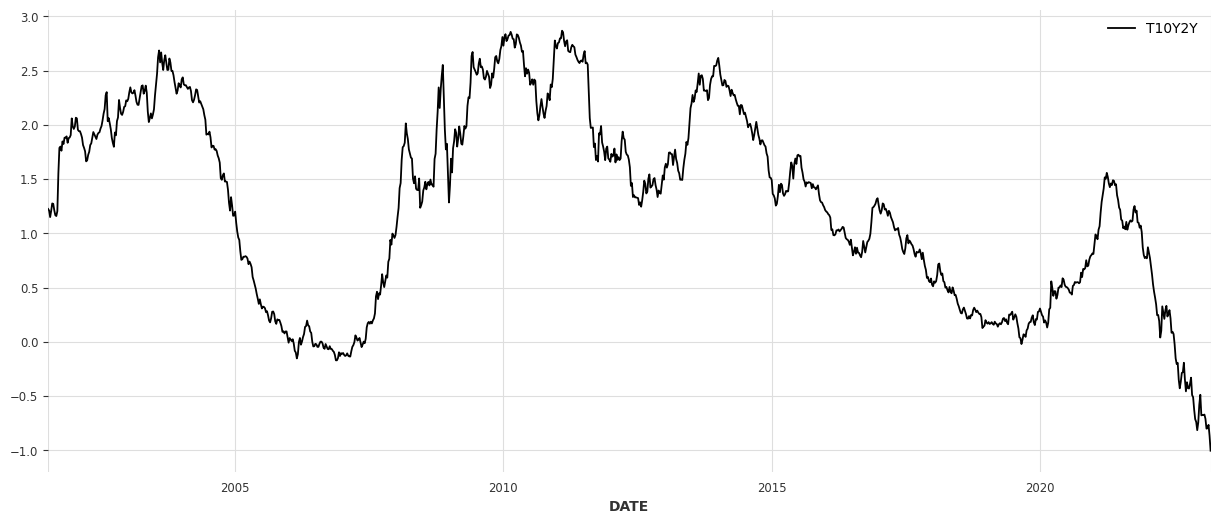

In [35]:
database2 = database2.resample('w').mean()
database2.plot(figsize=(15, 6))

In [36]:
jb_test = sm.stats.stattools.jarque_bera(database2)
print(jb_test)

(array([55.86828603]), array([7.38509069e-13]), array([-0.1483968]), array([1.9529087]))


<AxesSubplot: >

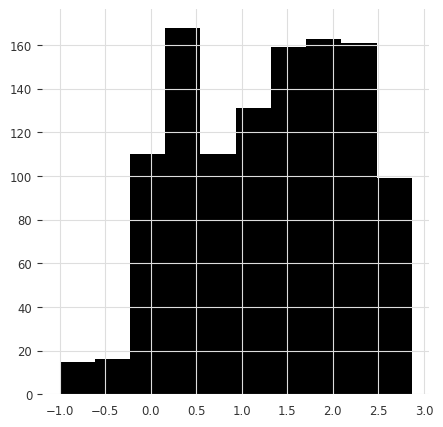

In [37]:
database2['T10Y2Y'].hist(figsize=(5,5))

In [38]:
test = sm.tsa.adfuller(database2)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -1.1943341771288043
p-value:  0.6760282445205129
Critical values:  {'1%': -3.436223122757065, '5%': -2.864133302917274, '10%': -2.5681507500224816}
есть единичные корни, ряд не стационарен


In [39]:
data2diff = database2.diff(periods=1).dropna()

In [40]:
test = sm.tsa.adfuller(data2diff)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.181410728786901
p-value:  2.643924545149456e-10
Critical values:  {'1%': -3.436223122757065, '5%': -2.864133302917274, '10%': -2.5681507500224816}
единичных корней нет, ряд стационарен


<AxesSubplot: xlabel='DATE'>

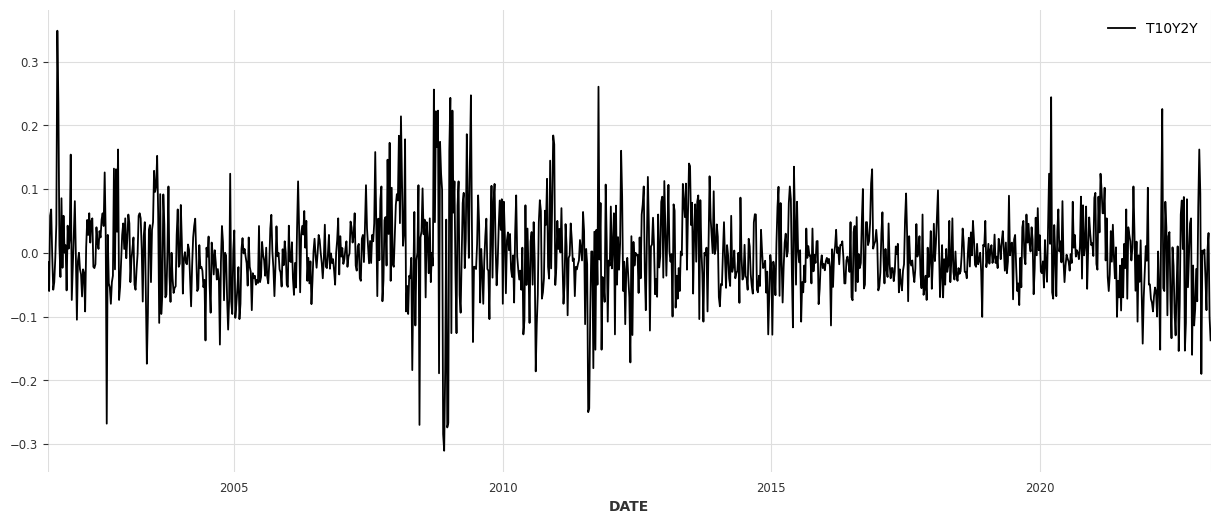

In [41]:
data2diff.plot(figsize=(15,6))

d:\programs\python\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


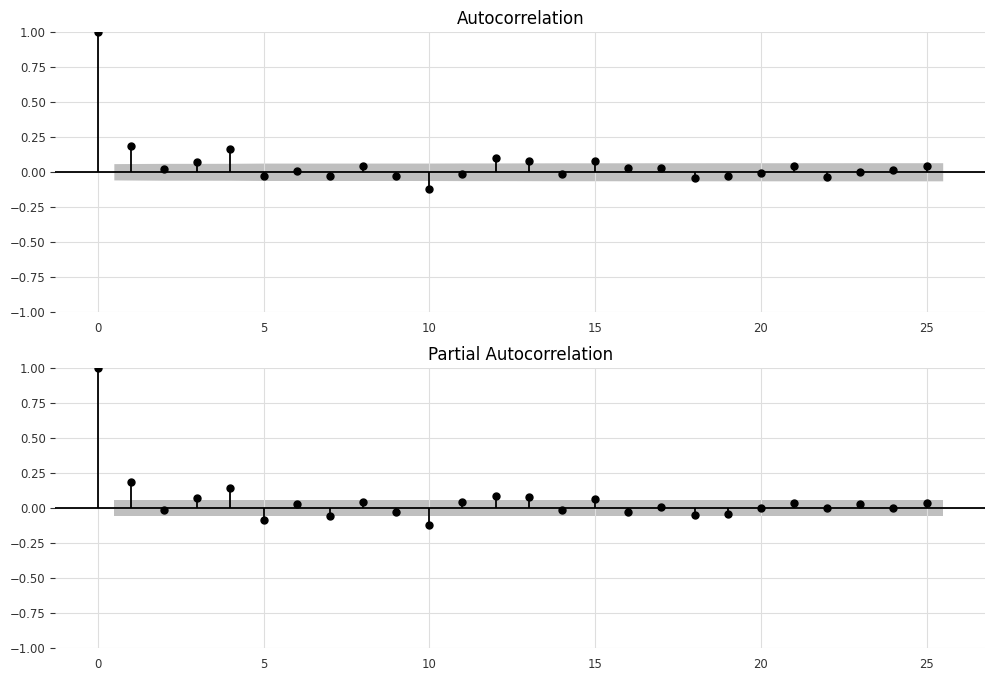

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data2diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data2diff, lags=25, ax=ax2)

In [43]:
src_data_model = database2[:'2022-09-01']

In [44]:
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                 1104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1427.438
Date:                Thu, 09 Mar 2023   AIC                          -2848.876
Time:                        22:34:28   BIC                          -2833.858
Sample:                    07-08-2001   HQIC                         -2843.195
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1763      0.104      1.688      0.091      -0.028       0.381
ma.L1          0.0166      0.105      0.159      0.874      -0.189       0.222
sigma2         0.0044      0.000     37.106      0.0

In [45]:
model = sm.tsa.ARIMA(src_data_model, order=(1,1,4), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                 1104
Model:                 ARIMA(1, 1, 4)   Log Likelihood                1448.573
Date:                Thu, 09 Mar 2023   AIC                          -2885.146
Time:                        22:34:29   BIC                          -2855.111
Sample:                    07-08-2001   HQIC                         -2873.785
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4342      0.103     -4.209      0.000      -0.636      -0.232
ma.L1          0.6296      0.107      5.885      0.000       0.420       0.839
ma.L2          0.0933      0.034      2.727      0.0

In [46]:
model = sm.tsa.ARIMA(src_data_model, order=(4,1,1), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                 1104
Model:                 ARIMA(4, 1, 1)   Log Likelihood                1449.315
Date:                Thu, 09 Mar 2023   AIC                          -2886.629
Time:                        22:34:29   BIC                          -2856.594
Sample:                    07-08-2001   HQIC                         -2875.268
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3464      0.084     -4.138      0.000      -0.510      -0.182
ar.L2          0.0859      0.027      3.130      0.002       0.032       0.140
ar.L3          0.0387      0.021      1.817      0.0

In [47]:
model = sm.tsa.ARIMA(src_data_model, order=(4,1,4), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                 1104
Model:                 ARIMA(4, 1, 4)   Log Likelihood                1450.338
Date:                Thu, 09 Mar 2023   AIC                          -2882.675
Time:                        22:34:31   BIC                          -2837.623
Sample:                    07-08-2001   HQIC                         -2865.634
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2721      0.168     -1.616      0.106      -0.602       0.058
ar.L2          0.1782      0.149      1.198      0.231      -0.113       0.470
ar.L3          0.0130      0.125      0.104      0.9

d:\programs\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
model = sm.tsa.ARIMA(src_data_model, order=(1,1,4), freq='W').fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 T10Y2Y   No. Observations:                 1104
Model:                 ARIMA(1, 1, 4)   Log Likelihood                1448.573
Date:                Thu, 09 Mar 2023   AIC                          -2885.146
Time:                        22:34:32   BIC                          -2855.111
Sample:                    07-08-2001   HQIC                         -2873.785
                         - 08-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4342      0.103     -4.209      0.000      -0.636      -0.232
ma.L1          0.6296      0.107      5.885      0.000       0.420       0.839
ma.L2          0.0933      0.034      2.727      0.0

<AxesSubplot: xlabel='DATE'>

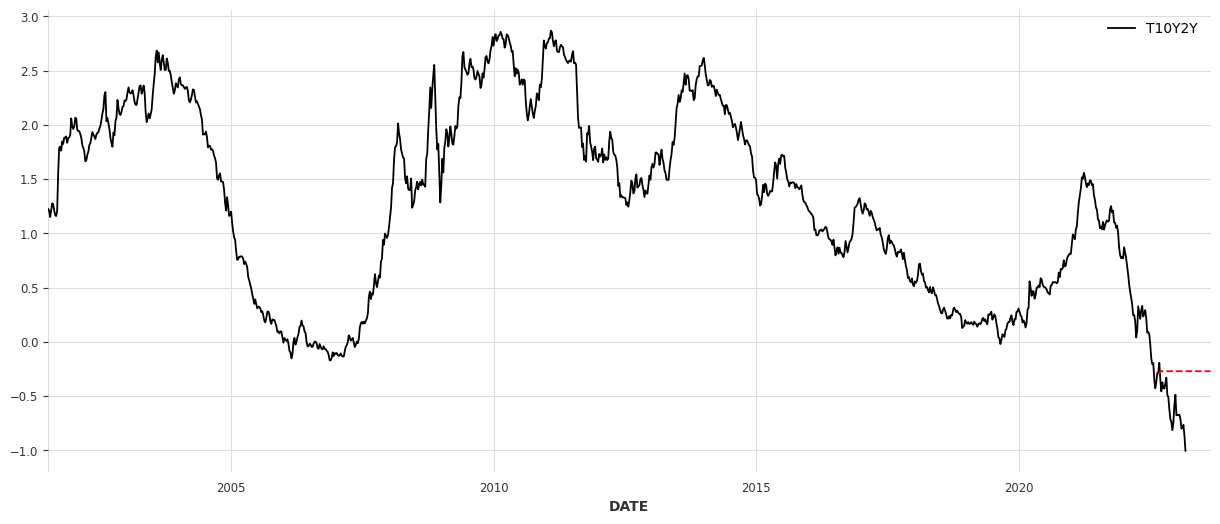

In [49]:
pred = model.predict('2022-09-01','2023-09-01', typ='levels')
database2.plot(figsize=(15, 6))
pred.plot(style='r--')

In [50]:
database = pd.read_csv("T10Y2Y.csv", sep = ',',  parse_dates=['DATE'], keep_default_na=False, dayfirst=True)
database['T10Y2Y'].loc[database['T10Y2Y'] == '.'] = np.nan
database['T10Y2Y'] = database['T10Y2Y'].astype(float)
database['T10Y2Y'] = database['T10Y2Y'].interpolate()

C:\Users\kolya\AppData\Local\Temp\ipykernel_80872\1017148150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database['T10Y2Y'].loc[database['T10Y2Y'] == '.'] = np.nan


In [51]:
series = TimeSeries.from_dataframe(database,  'DATE', 'T10Y2Y')

In [52]:
train, val = series.split_before(pd.Timestamp('20220901'))

In [53]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

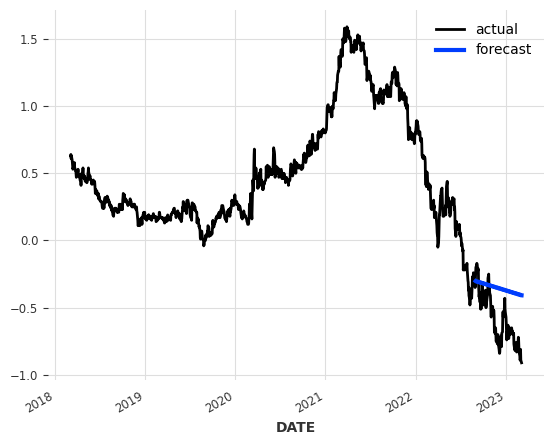

In [54]:
series.plot(label='actual')
prediction.plot(label='forecast',  lw=3)
plt.legend()

In [55]:
database = pd.read_csv("20.csv", sep = ',',  parse_dates=['DATE'], keep_default_na=False, dayfirst=True)
database['T10Y2Y'].loc[database['T10Y2Y'] == '.'] = np.nan
database['T10Y2Y'] = database['T10Y2Y'].astype(float)
database['T10Y2Y'] = database['T10Y2Y'].interpolate()

C:\Users\kolya\AppData\Local\Temp\ipykernel_80872\568946471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  database['T10Y2Y'].loc[database['T10Y2Y'] == '.'] = np.nan


In [56]:
series = TimeSeries.from_dataframe(database,  'DATE', 'T10Y2Y')
train, val = series.split_before(pd.Timestamp('20220901'))

In [57]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

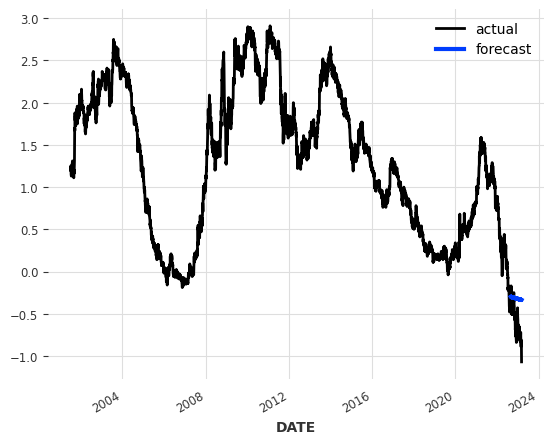

In [58]:
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)
plt.legend()

предикт дартса и ручной через ариму похожий, чтобы график сделать похожим и прогноз был более точным можно уменьшить датасет и проводить анализ с середины 2021 года(там график четко идет на спад и прогноз соответственно пойдет такой же). но если говорить о конкретных резултатах, то я готов сделать предположение(просмотрев график за многие годы), что данное падение именно тот случай, когда чтото пошло не так и как раз таки стоит искать выводы что такого случилось, что график отошел от предикта.